Datashader provides a flexible series of processing stages that map from raw data into viewable images. As shown in the [Introduction](1-Introduction.ipynb), using datashader can be as simple as calling ``datashade()``, but understanding each of these stages will help you get the most out of the library.  

The stages in a datashader pipeline are similar to those in a [3D graphics shading pipeline](https://en.wikipedia.org/wiki/Graphics_pipeline):

![pipeline diagram](data/pipeline2.png)

Here the computational steps are listed across the top of the diagram, while the data structures or objects are listed along the bottom. Breaking up the computations in this way is what makes Datashader able to handle arbitrarily large datasets, because only one stage (Aggregation) requires access to the entire dataset.  The remaining stages use a fixed-sized data structure regardless of the input dataset, allowing you to use any visualization or embedding methods you prefer without running into performance limitations.

In this notebook, we'll first put together a simple, artificial example to get some data, and then show how to configure and customize each of the data-processing stages involved:

1. [Projection](#Projection)
2. [Aggregation](#Aggregation)
3. [Transformation](#Transformation)
4. [Colormapping](#Colormapping)
5. [Embedding](#Embedding)

## Data

For an example, we'll construct a dataset made of five overlapping 2D Gaussian distributions with different &sigma;s (spatial scales).  By default we'll have 10,000 datapoints from each category, but you should see sub-second response times even for 1 million datapoints per category if you increase `num`. 

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict as odict

num=10000
np.random.seed(1)

dists = {cat: pd.DataFrame(odict([('x',np.random.normal(x,s,num)), 
                                  ('y',np.random.normal(y,s,num)), 
                                  ('val',val), 
                                  ('cat',cat)]))      
         for x,  y,  s,  val, cat in 
         [(  2,  2, 0.03, 10, "d1"), 
          (  2, -2, 0.10, 20, "d2"), 
          ( -2, -2, 0.50, 30, "d3"), 
          ( -2,  2, 1.00, 40, "d4"), 
          (  0,  0, 3.00, 50, "d5")] }

df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")

Datashader can work many different data objects provided by different data libraries depending on the type of data involved, such as columnar data in [Pandas](http://pandas.pydata.org) or [Dask](http://dask.pydata.org) dataframes, gridded multidimensional array data using [xarray](http://xarray.pydata.org), columnar data on GPUs using [cuDF](https://github.com/rapidsai/cudf), multidimensional arrays on GPUs using [CuPy](https://cupy.chainer.org/), and ragged arrays using [SpatialPandas](https://github.com/holoviz/spatialpandas) (see the [Performance User Guide](../10_Performance.ipynb) for a guide to selecting an appropriate library).  Here, we're using a Pandas dataframe, with 50,000 rows by default:

In [2]:
df.tail()

,x,y,val,cat
49995,-1.397579,0.610189,50,d5
49996,-2.649610,3.080821,50,d5
49997,1.933360,0.243676,50,d5
49998,4.306374,1.032139,50,d5
49999,-0.493567,-2.242669,50,d5


In [3]:
df.shape

(50000, 4)

To illustrate this dataset, we'll make a quick-and-dirty Datashader plot that dumps these x,y coordinates into an image:

In [6]:
#!pip install --user datashader

CPU times: user 1.19 s, sys: 266 ms, total: 1.46 s
Wall time: 4.06 s


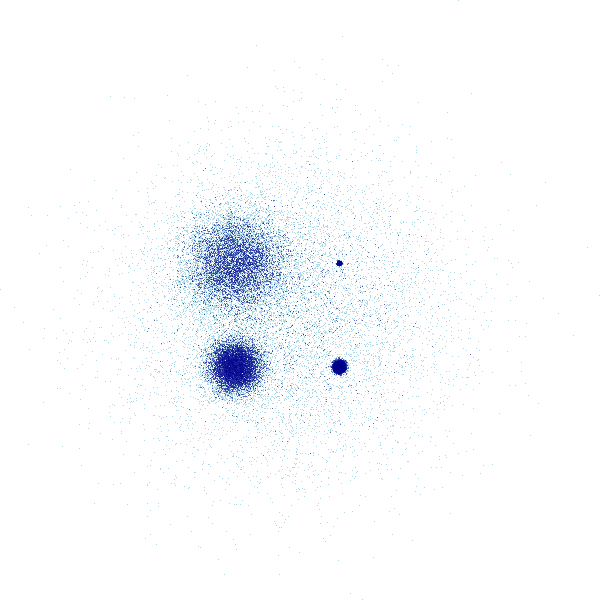

In [7]:
import datashader as ds
import datashader.transfer_functions as tf

%time tf.shade(ds.Canvas().points(df,'x','y'))

Without any special tweaking, datashader is able to reveal the overall shape of this distribution faithfully: four summed 2D normal distributions of different variances, arranged at the corners of a square, overlapping another very high-variance 2D normal distribution centered in the square.  This immediately obvious structure makes a great starting point for exploring the data, and you can then customize each of the various stages involved as described below.

Of course, this is just a static plot, and you can't see what the axes are, so we can instead embed this data into an interactive plot if we prefer:

Here, if you are running a live Python process, you can enable the "wheel zoom" tool on the right, zoom in anywhere in the distribution, and datashader will render a new image that shows the full distribution at that new location.  If you are viewing this on a static web site, zooming will simply make the existing set of pixels larger, because this dynamic updating requires Python.

Now that you can see the overall result, we'll unpack each of the steps in the Datashader pipeline and show how this image is constructed from the data.


## Projection

Datashader is designed to render datasets projected on to a 2D rectangular grid, eventually generating an image where each pixel corresponds to one cell in that grid.   The ***Projection*** stage is primarily conceptual, as it consists of you deciding what you want to plot and how you want to plot it:

- **Variables**: Select which variable you want to have on the *x* axis, and which one for the *y* axis.  If those variables are not already columns in your dataframe (e.g. if you want to do a coordinate transformation), you'll need to create suitable columns mapping directly to *x* and *y* for use in the next step.  For this example, the "x" and "y" columns are conveniently named `x` and `y` already, but any column name can be used for these axes.
- **Ranges**: Decide what ranges of those values you want to map onto the scene.  If you omit the ranges, datashader will calculate the ranges from the data values, but you will often wish to supply explicit ranges for three reasons:
   1. Calculating the ranges requires a complete pass over the data, which takes nearly as much time as actually aggregating the data, so your plots will be about twice as fast if you specify the ranges.
   2. Real-world datasets often have some outliers with invalid values, which can make it difficult to see the real data, so after your first plot you will often want to specify only the range that appears to have valid data.
   3. Over the valid range of data, you will often be mainly interested in a specific region, allowing you to zoom in to that area (though with an interactive plot you can always do that as needed).
- **Axis types**: Decide whether you want `'linear'` or `'log'` axes.
- **Resolution**: Decide what size of aggregate array you are going to want. 

Here's an example of specifying a ``Canvas`` (a.k.a. "Scene") object for a 200x200-pixel image covering the range +/-8.0 on both axes:

In [8]:
canvas = ds.Canvas(plot_width=300, plot_height=300, 
                   x_range=(-8,8), y_range=(-8,8), 
                   x_axis_type='linear', y_axis_type='linear')

At this stage, no computation has actually been done -- the `canvas` object is a purely declarative, recording your preferences to be applied in the next stage. 

<!-- Need to move the Points/Lines/Rasters discussion into the section above once the API is rationalized, and rename Canvas to Scene. -->


## Aggregation

<!-- This section really belongs under Scene, above-->

Once a `Canvas` object has been specified, it can then be used to guide aggregating the data into a fixed-sized grid. Data is assumed to consist of a series of items, each of which has some visible representation (its rendering as a "glyph") that is combined with the representation of other items to produce an aggregate representation of the whole set of items in the rectangular grid. The available glyph types for representing a data item are currently:
   - **Canvas.points**: each data item is a coordinate location (an x,y pair), mapping into the single closest grid cell to that datapoint's location.
   - **Canvas.line**: each data item is a coordinate location, mapping into every grid cell falling between this point's location and the next in a straight line segment.
   - **Canvas.area**: each data item is a coordinate location, rendered as a shape filling the axis-aligned area between this point, the next point, and a baseline (e.g. zero, filling the area between a line and a base).
   - **Canvas.trimesh**: each data item is a triple of coordinate locations specifying a triangle, filling in the region bounded by that triangle.
   - **Canvas.polygons**: each data item is a sequence of coordinate locations specifying a polygon, filling in the region bounded by that polygon (minus holes if specified separately).
   - **Canvas.raster**: the collection of data items is an array specifying regularly spaced axis-aligned rectangles forming a regular grid; each cell in this array is rendered as a filled rectangle.
   - **Canvas.quadmesh**: the collection of data items is an array specifying irregularly spaced quadrilaterals forming a grid that is regular in the input space but can have arbitrary rectilinear or curvilinear shapes in the aggregate grid; each cell in this array is rendered as a filled quadrilateral.

These types are each covered in detail in the [User Guide](../user_guide/).  Datashader can be extended to add additional types here and in each section below; see  [Extending Datashader](../user_guide/9-Extending.ipynb) for more details.  Many other plots like time series and network graphs can be constructed out of these basic primitives.


<!-- (to here) -->

### Reductions

One you have determined your mapping, you'll next need to choose a reduction operator to use when aggregating multiple datapoints into a given pixel. For points, each datapoint is mapped into a single pixel, while the other glyphs have spatial extent and can thus map into multiple pixels, each of which operates the same way. All glyphs act like points if the entire glyph is contained within that pixel. Here we will talk only about "datapoints" for simplicity, which for an area-based glyph should be interpreted as "the part of that glyph that falls into this pixel".

All of the currently supported reduction operators are incremental, which means that we can efficiently process datasets in a single pass. Given an aggregate bin to update (typically corresponding to one eventual pixel) and a new datapoint, the reduction operator updates the state of the bin in some way. (Actually, datapoints are normally processed in batches for efficiency, but it's simplest to think about the operator as being applied per data point, and the mathematical result should be the same.) A large number of useful [reduction operators]((https://datashader.org/api.html#reductions) are supplied in `ds.reductions`, including:

**`count(column=None)`**:
  increment an integer count each time a datapoint maps to this bin. The resulting aggregate array will be an unsigned integer type, allowing counts to be distinguished from the other types that are normally floating point.
  
**`any(column=None)`**:
  the bin is set to 1 if any datapoint maps to it, and 0 otherwise.
  
**`sum(column)`**:
  add the value of the given column for this datapoint to a running total for this bin.
   
**`by(column, reduction)`**:
  given a bin with categorical data (i.e., [Pandas' `categorical` datatype](https://pandas-docs.github.io/pandas-docs-travis/categorical.html)), aggregate each category separately, accumulating the given datapoint in an appropriate category within this bin.  These categories can later be collapsed into a single aggregate if needed; see examples below.
  
**`summary(name1=op1,name2=op2,...)`**:
  allows multiple reduction operators to be computed in a single pass over the data; just provide a name for each resulting aggregate and the corresponding reduction operator to use when creating that aggregate. If multiple aggregates are needed for the same dataset and the same Canvas, using `summary` will generally be much more efficient than making multiple separate passes over the dataset.
  
The API documentation contains the complete list of [reduction operators]((https://datashader.org/api.html#reductions) provided, including `mean`, `min`, `max`, `var` (variance), `std` (standard deviation).  The reductions are also imported into the ``datashader`` namespace for convenience, so that they can be accessed like ``ds.mean()`` here.

For the operators above, those accepting a `column` argument will only do the operation if the value of that column for this datapoint is not `NaN`.  E.g. `count` with a column specified will count the datapoints having non-`NaN` values for that column.

Once you have selected your reduction operator, you can compute the aggregation for each pixel-sized aggregate bin:

In [9]:
canvas.points(df, 'x', 'y', agg=ds.count())

<xarray.DataArray (y: 300, x: 300)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * x        (x) float64 -7.973 -7.92 -7.867 -7.813 ... 7.813 7.867 7.92 7.973
  * y        (y) float64 -7.973 -7.92 -7.867 -7.813 ... 7.813 7.867 7.92 7.973

The result of will be an [xarray](http://xarray.pydata.org) `DataArray` data structure containing the bin values (typically one value per bin, but more for multiple category or multiple-aggregate operators) along with axis range and type information.

We can visualize this array in many different ways by customizing the pipeline stages described in the following sections, but for now we'll simply render images using the default parameters to show the effects of a few different aggregate operators:

count(),any(),mean('y'),50- mean('val')

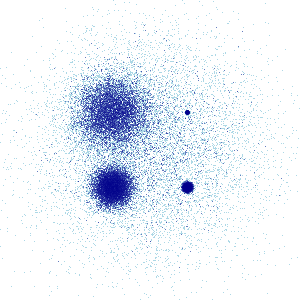
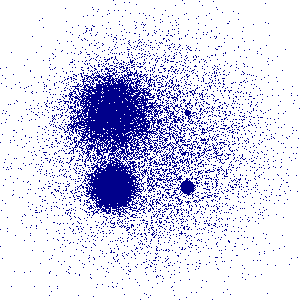
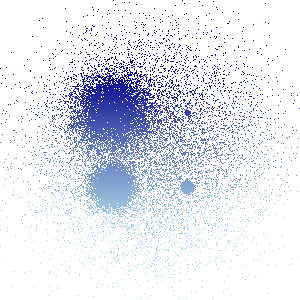
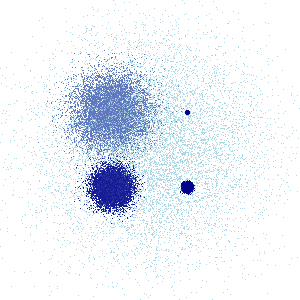

In [10]:
tf.Images(tf.shade(   canvas.points(df,'x','y', ds.count()),     name="count()"),
          tf.shade(   canvas.points(df,'x','y', ds.any()),       name="any()"),
          tf.shade(   canvas.points(df,'x','y', ds.mean('y')),   name="mean('y')"),
          tf.shade(50-canvas.points(df,'x','y', ds.mean('val')), name="50- mean('val')"))

Here ``count()`` renders each bin's count in a different color, to show the true distribution, while ``any()`` turns on a pixel if any point lands in that bin, and ``mean('y')`` averages the `y` column for every datapoint that falls in that bin. Of course, since ever datapoint falling into a bin happens to have the same `y` value, the mean reduction with `y` simply scales each pixel by its `y` location.  

For the last image above, we specified that the `val` column should be used for the `mean` reduction, which in this case results in each category being assigned a different color, because in our dataset all items in the same category happen to have the same `val`.  Here we also manipulated the result of the aggregation before displaying it by subtracting it from 50, as detailed in the next section.



## Transformation

Now that the data has been projected and aggregated into a gridded data structure, it can be processed in any way you like, before converting it to an image as will be described in the following section.  At this stage, the data is still stored as bin data, not pixels, which makes a very wide variety of operations and transformations simple to express.  

For instance, instead of plotting all the data, we can easily plot only those bins in the 99th percentile by count (left), or apply any [NumPy ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) to the bin values (whether or not it makes any sense!):

99th Percentile,Numpy square ufunc,Numpy sin ufunc

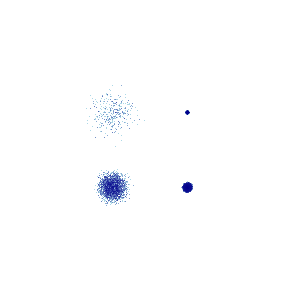
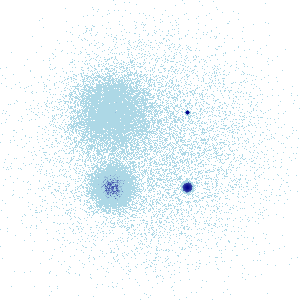
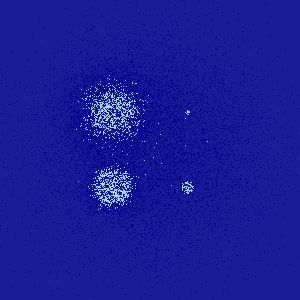

In [11]:
agg  = canvas.points(df, 'x', 'y')

tf.Images(tf.shade(agg.where(agg>=np.percentile(agg,99)), name="99th Percentile"),
          tf.shade(np.power(agg,2),                       name="Numpy square ufunc"),
          tf.shade(np.sin(agg),                           name="Numpy sin ufunc"))

The [xarray documentation](http://xarray.pydata.org/en/stable/computation.html) describes all the various transformations you can apply from within xarray, and of course you can always extract the data values and operate on them outside of xarray for any transformation not directly supported by xarray, then construct a suitable xarray object for use in the following stage.  Once the data is in the aggregate array, you generally don't have to worry much about optimization, because it's a fixed-sized grid regardless of your data size, and so it is very straightforward to apply arbitrary transformations to the aggregates.

The above examples focus on a single aggregate, but there are many ways that you can use multiple data values per bin as well.  For instance, you can apply any aggregation "categorically", aggregating `by` some categorical value so that datapoints for each unique value are aggregated independently:

In [12]:
aggc = canvas.points(df, 'x', 'y', ds.by('cat', ds.count()))
aggc

<xarray.DataArray (y: 300, x: 300, cat: 5)>
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=uint32)
Coordinates:
  * x        (x) float64 -7.973 -7.92 -7.867 -7.813 ... 7.813 7.867 7.92 7.973
  * y        (y) float64 -7.973 -7.92 -7.867 -7.813 ... 7.813 7.867 7.92 7.973
  * cat      (cat) <U2 'd1' 'd2' 'd3' 'd4' 'd5'

Here the `count()` aggregate has been collected into not just a 2D aggregate array, but a whole stack of aggregate arrays, one per `cat` value, making the aggregate be three dimensional (x,y,cat) rather than just two (x,y). With this 3D aggregate of counts per category, you can then select a specific category or subset of them for further processing, where `.sum(dim='cat')` will collapse across such a subset to give a single aggregate array:

In [14]:
agg_d3_d5=aggc.sel(cat=['d3', 'd5']).sum(dim='cat')

tf.Images(tf.shade(aggc.sel(cat='d3'), name="Category d3"),
          tf.shade(agg_d3_d5,          name="Categories d3 and d5"))          

TypeError: 'numpy.float64' object cannot be interpreted as an integer

You can also combine multiple aggregates however you like, as long as they were all constructed using the same Canvas object (which ensures that their aggregate arrays are the same size) and cover the same axis ranges:

d3+d5 where d3==d5,d1+d2+d3+d4+d5 where d3==d5

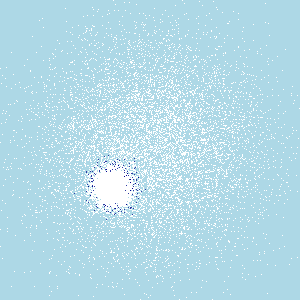
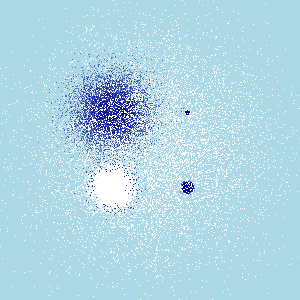

In [15]:
tf.Images(tf.shade(agg_d3_d5.where(aggc.sel(cat='d3') == aggc.sel(cat='d5')), name="d3+d5 where d3==d5"),
          tf.shade(      agg.where(aggc.sel(cat='d3') == aggc.sel(cat='d5')), name="d1+d2+d3+d4+d5 where d3==d5"))

The above two results are using the same mask (only those bins `where` the counts for 'd3' and 'd5' are equal), but applied to different aggregates (either just the `d3` and `d5` categories, or the entire set of counts).

## Colormapping

As you can see above, the usual way to visualize an aggregate array is to map from each array bin into a color for a corresponding pixel in an image.  The above examples use the `tf.shade()` method, which maps a scalar aggregate bin value into an RGB (color) triple and an alpha (opacity) value.  By default, the colors are chosen from the colormap ['lightblue','darkblue'] (i.e., `#ADD8E6` to `#00008B`), with intermediate colors chosen as a linear interpolation independently for the red, green, and blue color channels (e.g. `AD` to `00` for the red channel, in this case).  The alpha (opacity) value is set to 0 for empty bins and 1 for non-empty bins, allowing the page background to show through wherever there is no data.  You can supply any colormap you like, including Bokeh palettes, Matplotlib colormaps, or a list of colors (using the color names from `ds.colors`, integer triples, or hexadecimal strings):

"darkred, yellow","yellow, orange red, dark purple",Bokeh RdBu9,Black

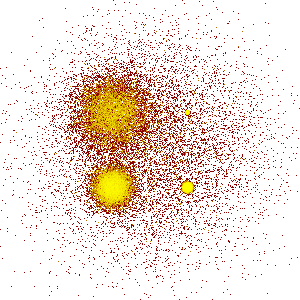
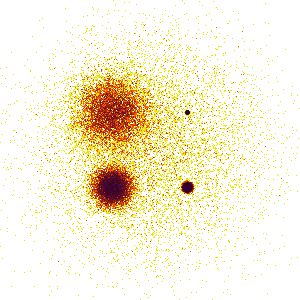
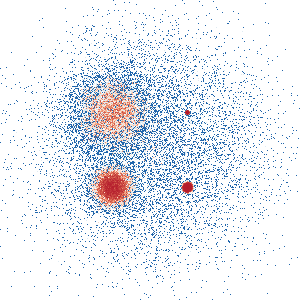
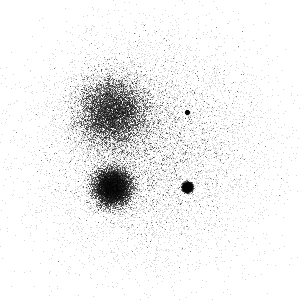

In [16]:
from bokeh.palettes import RdBu9
tf.Images(tf.shade(agg,cmap=["darkred", "yellow"], name="darkred, yellow"),
          tf.shade(agg,cmap=[(230,230,0), "orangered", "#300030"], name="yellow, orange red, dark purple"), 
          tf.shade(agg,cmap=list(RdBu9), name="Bokeh RdBu9"),
          tf.shade(agg,cmap="black", name="Black"))

As a special case ("Black", above), if you supply only a single color, the color will be kept constant at the given value but the alpha (opacity) channel will vary with the data.

#### Colormapping categorical data

If you want to use `tf.shade` with a categorical aggregate, you can use a colormap just as for a non-categorical aggregate if you first select a single category using something like `aggc.sel(cat='d3')` or else collapse all categories into a single aggregate using something like `aggc.sum(dim='cat')`.  

If you want to visualize all the categories in one image, you can use `tf.shade` with the categorical aggregate directly, which will assign a color to each category and then calculate the transparency and color of each pixel according to each category's contribution to that pixel:

Default color key,Custom color key

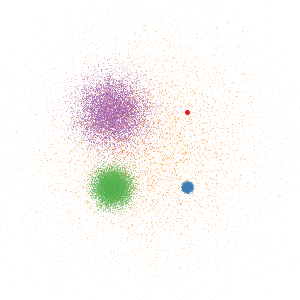
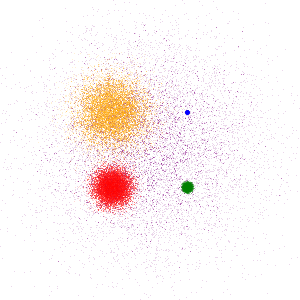

In [17]:
color_key = dict(d1='blue', d2='green', d3='red', d4='orange', d5='purple')

tf.Images(tf.shade(aggc, name="Default color key"),
          tf.shade(aggc, color_key=color_key, name="Custom color key"))

Here the different colors mix not just visually due to blurring, but are actually mixed mathematically per pixel, with pixels that include data from multiple categories taking intermediate color values.  The total (summed) data values across all categories are used to calculate the alpha channel, with the previously computed color being revealed to a greater or lesser extent depending on the value of the aggregate for that bin. See [Colormapping with negative values](#Colormapping-with-negative-values) below for more details on how these colors and transparencies are calculated.

The default color key for categorical data provides distinguishable colors for a couple of dozen categories, but you can provide an explicit color_key if you prefer. Choosing colors for different categories is more of an art than a science, because the colors not only need to be distinguishable, their combinations also need to be distinguishable if those categories ever overlap in nearby pixels, or else the results will be ambiguous.  In practice, only a few categories can be reliably distinguished in this way, but [zooming in](3_Interactivity.ipynb) can be used to help disambiguate overlapping colors, as long as the basic set of colors is itself distinguishable.

#### Transforming data values for colormapping

In each of the above examples, you may have noticed that we were never required to specify any parameters about the data values; the plots just appear like magic.  That magic is implemented in `tf.shade`.  What `tf.shade` does for a 2D aggregate (non-categorical) is:

1. **Mask** out all bins with a `NaN` value (for floating-point arrays) or a zero value (for the unsigned integer arrays that are returned from `count`); these bins will not have any effect on subsequent computations.  

2. **Transform** the bin values using a specified scalar function `how`.  Calculates the value of that function for the difference between each bin value and the minimum non-masked bin value.  E.g. for `how="linear"`, simply returns the difference unchanged.  Other `how` functions are discussed below.

3. **Map** the resulting transformed data array into the provided colormap.  First finds the value span (*l*,*h*) for the resulting transformed data array -- what are the lowest and highest non-masked values?  -- and then maps the range (*l*,*h*) into the full range of the colormap provided. If a colormap is used, masked values are given a fully transparent alpha value, and non-masked ones are given a fully opaque alpha value. If a single color is used, the alpha value starts at `min_alpha` and increases proportionally to the mapped data value up to the full `alpha` value.

The result is thus auto-ranged to show whatever data values are found in the aggregate bins, with the `span` argument (described below) allowing you to override the range explicitly if you need to.

As described in [Plotting Pitfalls](../user_guide/1_Plotting_Pitfalls.ipynb), auto-ranging is only part of what is required to reveal the structure of the dataset; it's also crucial to automatically and potentially nonlinearly map from the aggregate values (e.g. bin counts) into the colormap. If we used a linear mapping, we'd see very little of the structure of the data:

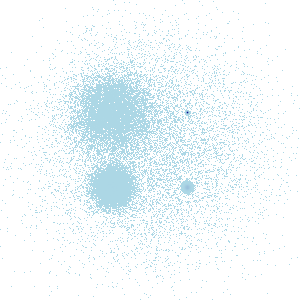

In [18]:
tf.shade(agg,how='linear')

In the linear version, you can see that the bins that have zero count show the background color, since they have been masked out using the alpha channel of the image, and that the rest of the pixels have been mapped to colors near the bottom of the colormap.  If you peer closely at it, you may even be able to see that one pixel (from the smallest Gaussian) has been mapped to the highest color in the colormap (here dark blue).  But no other structure is visible, because the highest-count bin is so much higher than all of the other bins:

In [19]:
top15=agg.values.flat[np.argpartition(agg.values.flat, -15)[-15:]]
print(sorted(top15))
print(sorted(np.round(top15*255.0/agg.values.max()).astype(int)))

[342, 345, 345, 351, 355, 357, 363, 392, 399, 405, 1075, 1148, 1169, 1172, 3918]
[22, 22, 22, 23, 23, 23, 24, 26, 26, 26, 70, 75, 76, 76, 255]


I.e., if using a colormap with 255 colors, the largest bin (`agg.values.max()`) is mapped to the highest color, but with a linear scale all of the other bins map to only the first 24 colors, leaving all intermediate colors unused.  If we want to see any structure for these intermediate ranges, we need to transform these numerical values somehow before displaying them.  For instance, if we take the logarithm of these large values, they will be mapped into a more tractable range:

In [20]:
print(np.log1p(sorted(top15)))

[5.83773045 5.84643878 5.84643878 5.86363118 5.87493073 5.88053299
 5.89715387 5.97380961 5.99146455 6.00635316 6.98100574 7.04664728
 7.06475903 7.06731985 8.2735918 ]


So we can plot the logarithms of the values (``how='log'``, below), which is an arbitrary transform but is appropriate for many types of data.  Alternatively, we can make a histogram of the numeric values, then assign a pixel color to each equal-sized histogram bin to ensure even usage of every displayable color (``how='eq_hist'``; see [plotting pitfalls](../user_guide/1_Plotting_Pitfalls.ipynb). We can even supply any arbitrary transformation to the colormapper as a callable, such as a twenty-third root:

log,eq_hist,23rd root

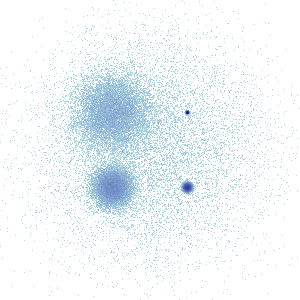
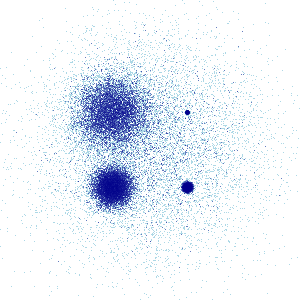
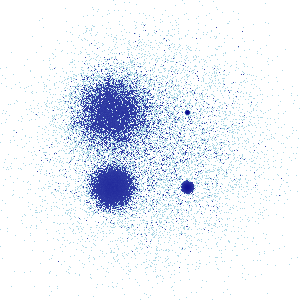

In [21]:
tf.Images(tf.shade(agg,how='log', name="log"),
          tf.shade(agg,how='eq_hist', name="eq_hist"),
          tf.shade(agg,how=lambda d, m: np.where(m, np.nan, d)**(1/23.), name="23rd root"))

Usually, however, such custom operations are done directly on the aggregate during the ***Transformation*** stage; the `how` operations are meant for simple, well-defined transformations solely for the final steps of visualization, which allows the main aggregate array to stay in the original units and scale in which it was measured.  Using `how` also helps simplify the subsequent ***Embedding*** stage, letting it provide one of a fixed set of legend types, either linear (for `how=linear`), logarithmic (for `how=log`) or percentile (for `how=eq_hist`).  See the [shade docs](https://datashader.org/api.html#datashader.transfer_functions.shade) for more details on the `how` functions. 

For categorical aggregates, the `shade` function works similarly to providing a single color to a non-categorical aggregate, with the alpha (opacity) calculated from the total value across all categories (and the color calculated as a weighted mixture of the colors for each category).

#### Controlling ranges for colormapping

By default, `shade` will autorange on the aggregate array, mapping the lowest and highest values of the aggregate array into the lowest and highest values of the colormap (or the available alpha values, for single colors). You can instead focus on a specific `span` of the aggregate data values, mapping that span into the available colors or the available alpha values:

gb 0 20,gb 50 200,Green 10 20

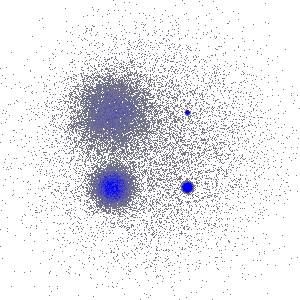
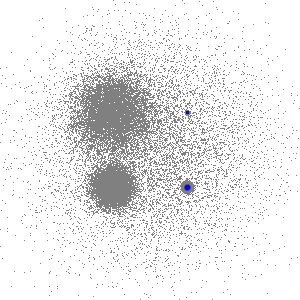
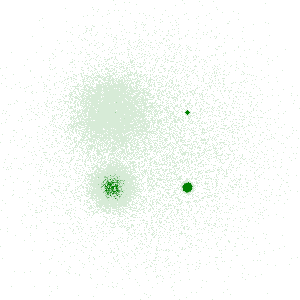

In [22]:
tf.Images(tf.shade(agg,cmap=["grey", "blue"], name="gb 0 20",   span=[0,20],   how="linear"),
          tf.shade(agg,cmap=["grey", "blue"], name="gb 50 200", span=[50,200], how="linear"),
          tf.shade(agg,cmap="green",        name="Green 10 20", span=[10,20],  how="linear"))

On the left, all counts above 20 are mapped to the highest value in the colormap (blue in this case), losing the ability to distinguish between values above 20 but providing the maximum color precision for the specific range 0 to 20.  In the middle, all values 0 to 50 map to the first color in the colormap (grey in this case), and the colors are then linearly interpolated up to 200, with all values 200 and above mapping to the highest value in the colormap (blue in this case). With the single color mapping to alpha on the right, counts up to 10 are all mapped to `min_alpha`, counts 20 and above are all mapped to the specified `alpha` (255 in this case), and alpha is scaled linearly in between.

For plots that scale with alpha (i.e., categorical or single-color non-categorical plots), you can control the range of alpha values generated by setting `min_alpha` (lower bound) and `alpha` (upper bound), on a scale 0 to 255):

Green,No min_alpha,Small alpha range

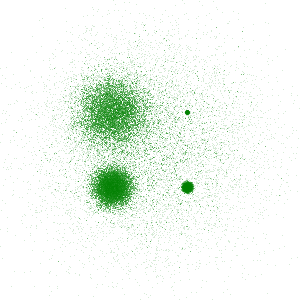
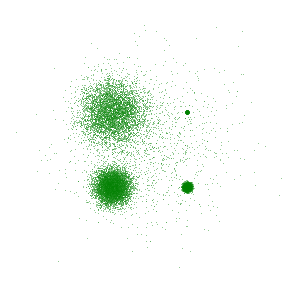
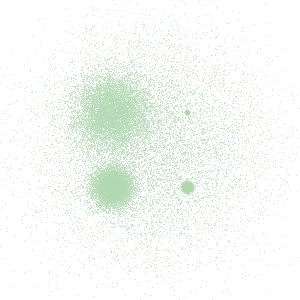

In [23]:
tf.Images(tf.shade(agg,cmap="green", name="Green"),
          tf.shade(agg,cmap="green", name="No min_alpha",      min_alpha=0), 
          tf.shade(agg,cmap="green", name="Small alpha range", min_alpha=50, alpha=80))

Here you can see that the faintest pixels are more visible with the default `min_alpha` (normally 40, left) than if you explicitly set the `min_alpha=0` (middle), which is why the `min_alpha` default is non-zero; otherwise low values would be indistinguishable from the background (see [Plotting Pitfalls](../user_guide/1_Plotting_Pitfalls.ipynb)).

You can combine `span` and `alpha` ranges to specifically control the data value range that maps to an opacity range, for single-color and categorical plotting:

"g 0,20","g 10,20","g 10,20 0"

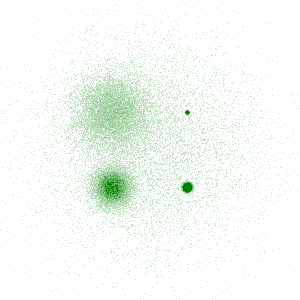
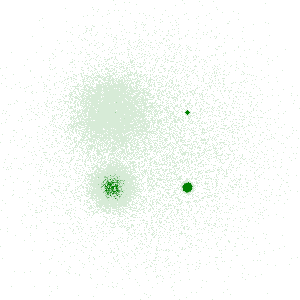
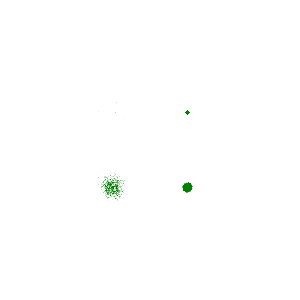

In [24]:
tf.Images(tf.shade(agg,cmap="green", name="g 0,20",    span=[ 0,20], how="linear"),
          tf.shade(agg,cmap="green", name="g 10,20",   span=[10,20], how="linear"),
          tf.shade(agg,cmap="green", name="g 10,20 0", span=[10,20], how="linear", min_alpha=0))

eq_hist,linear,"span 0,10","span 0,10"

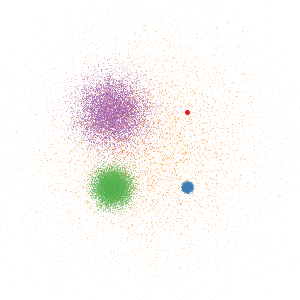
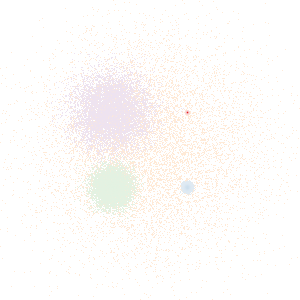
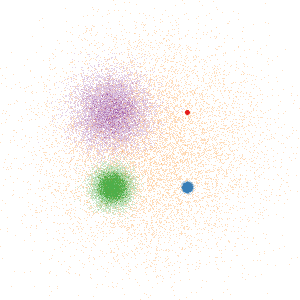
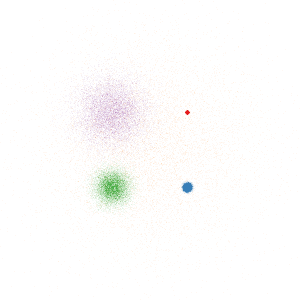

In [25]:
tf.Images(tf.shade(aggc, name="eq_hist"),
          tf.shade(aggc, name="linear",    how='linear'),
          tf.shade(aggc, name="span 0,10", how='linear', span=(0,10)), 
          tf.shade(aggc, name="span 0,10", how='linear', span=(0,20), min_alpha=0))

The categorical examples above focus on counts, but `ds.by` works on other aggregate types as well, colorizing by category but aggregating by sum, mean, etc. (but see the [following section](#Colormapping-with-negative-values) for details on how to interpret such colors):

,,

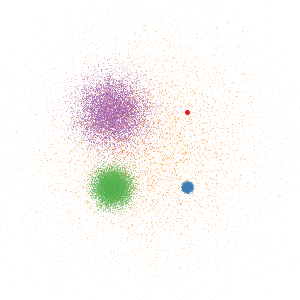
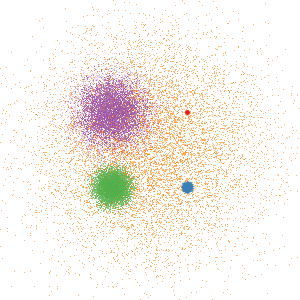
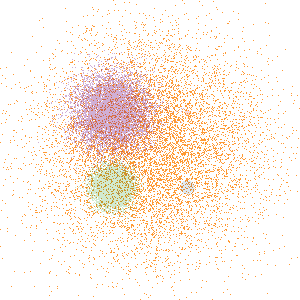

In [26]:
agg_c = canvas.points(df,'x','y', ds.by('cat', ds.count()))
agg_s = canvas.points(df,'x','y', ds.by("cat", ds.sum("val")))
agg_m = canvas.points(df,'x','y', ds.by("cat", ds.mean("val")))

tf.Images(tf.shade(agg_c), tf.shade(agg_s), tf.shade(agg_m))

#### Colormapping with negative values

The above examples all use positive data values to avoid confusion when there is no colorbar or other explicit indication of a z (color) axis range.  Negative values are also supported, in which case for a non-categorical plot you should normally use a [diverging colormap](https://colorcet.holoviz.org/user_guide/Continuous.html#Diverging-colormaps,-for-plotting-magnitudes-increasing-or-decreasing-from-a-central-point:):

Sequential,DivergingW,DivergingB

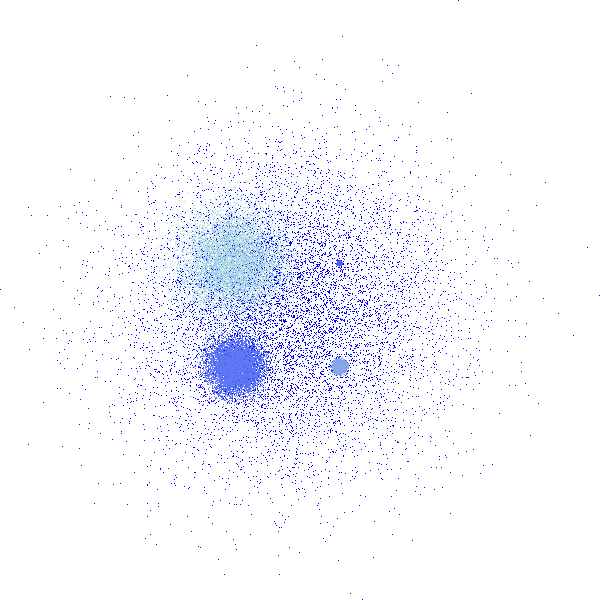
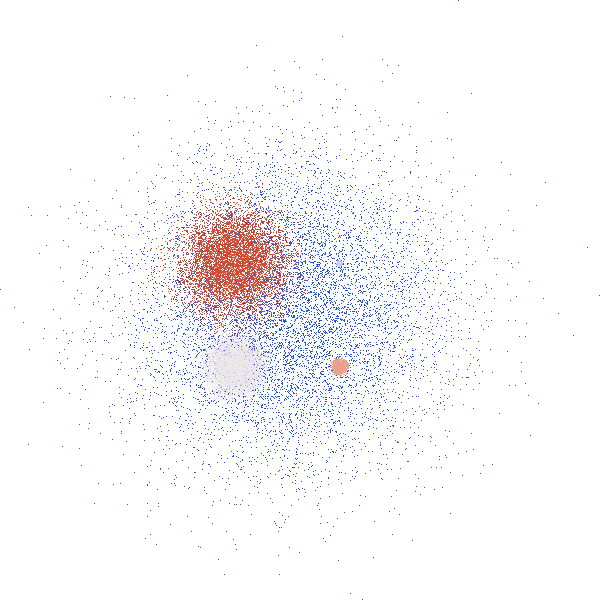
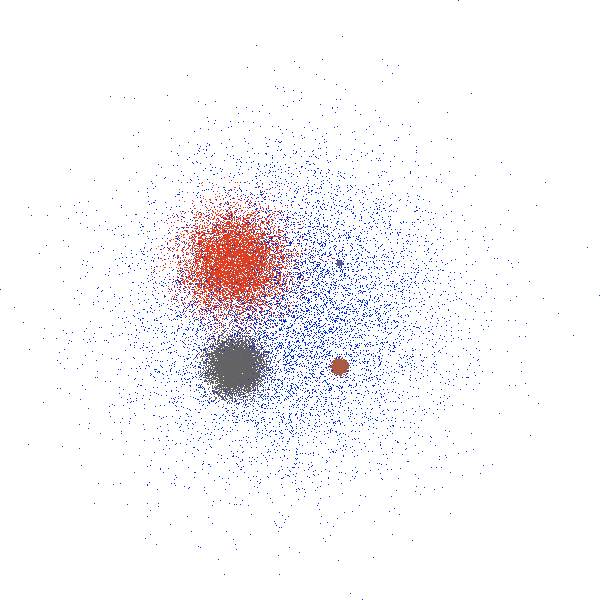

In [27]:
from colorcet import coolwarm, CET_D8
dfn = df.copy()
dfn.val.replace({20:-20, 30:0, 40:-40}, inplace=True)
aggn = ds.Canvas().points(dfn,'x','y', agg=ds.mean("val"))

tf.Images(tf.shade(aggn, name="Sequential", cmap=["lightblue","blue"], how="linear"),
          tf.shade(aggn, name="DivergingW", cmap=coolwarm[::-1], span=(-50,50), how="linear"),
          tf.shade(aggn, name="DivergingB", cmap=CET_D8[::-1],   span=(-50,50), how="linear"))

In both of the above plots, values with no data are transparent as usual, showing white. With a sequential lightblue to blue colormap, increasing `val` numeric values are mapped to the colormap in order, with the smallest values (-40; large blob in the top left) getting the lowest color value (lightblue), less negative values (-20, blob in the bottom right) getting an intermediate color, and the largest average values (50, large distribution in the background) getting the highest color. Looking at such a plot, viewers have no easy way to determine which values are negative. Using a diverging colormap (right two plots) and forcing the span to be symmetric around zero ensures that negative values are plotted in one color range (reds) and positive are plotted in a clearly different range (blues). Note that when using a diverging colormap with transparent values, you should carefully consider what you want to happen around the zero point; here values with nearly zero average (blob in bottom left) disappear when using a white-centered diverging map ("coolwarm"), while they show up but in a neutral color when using a diverging map with a contrasting central color ("CET_D8").

For categorical plots of values that can be negative, the results are often quite difficult to interpret, for the same reason as for the Sequential case above:

count,sum,sum baseline=0

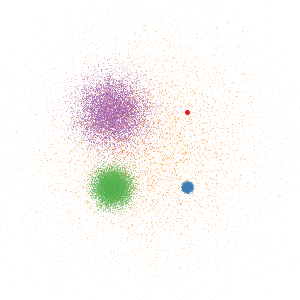
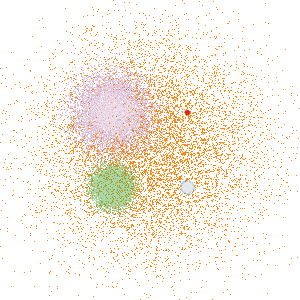
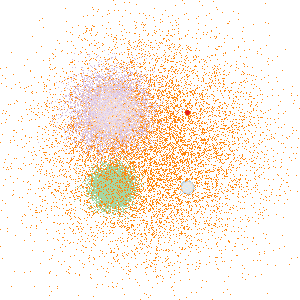

In [28]:
agg_c = canvas.points(dfn,'x','y', ds.by('cat', ds.count()))
agg_s = canvas.points(dfn,'x','y', ds.by("cat", ds.sum("val")))
agg_m = canvas.points(dfn,'x','y', ds.by("cat", ds.mean("val")))

tf.Images(tf.shade(agg_c, name="count"), 
          tf.shade(agg_s, name="sum"), 
          tf.shade(agg_s, name="sum baseline=0", color_baseline=0))

Here a `count` aggregate ignores the negative values and thus works the same as when values were positive, but `sum` and other aggregates like `mean` take the negative values into account. By default, a pixel with the lowest value (whether negative or positive) maps to `min_alpha`, and the highest maps to `alpha`.  The color is determined by how different each category's value is from the minimum value across all categories; categories with high values relative to the minimum contribute more to the color. There is not currently any way to tell which data values are positive or negative, as you can using a diverging colormap in the non-categorical case.

Instead of using the default of the data minimum, you can pass a specific `color_baseline`, which is appropriate if your data has a well-defined reference value such as zero. Here, when we pass `color_baseline=0` the negative values are essentially ignored for color calculations, which can be seen on the green blob, where any orange data point is fully orange despite the presence of green-category datapoints; the middle plot `sum` shows a more appropriate color mixture in that case.

#### Spreading

Once an aggregate or image  has been created, it can be further transformed with a set of functions from `ds.transfer_functions`.

For instance, because it can be difficult to see individual dots, particularly for zoomed-in plots, you can transform the aggregate to replace each bin with a shape, such as a circle (default) or square.  This process is called spreading:

Original image,spread 1px,spread 2px,spread square

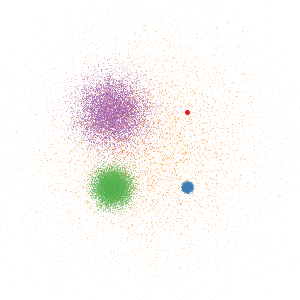
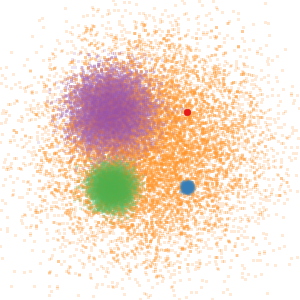
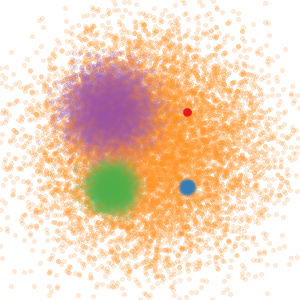
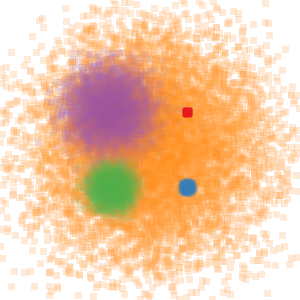

In [29]:
img = tf.shade(aggc, name="Original image")
tf.Images(img,
          tf.shade(tf.spread(aggc,       name="spread 1px")),
          tf.shade(tf.spread(aggc, px=2, name="spread 2px")),
          tf.shade(tf.spread(aggc, px=3, shape='square', name="spread square")))


As you can see, spreading is very effective for isolated datapoints, which is what it's normally used for, but it has overplotting-like effects for closely spaced points like in the green and purple regions above, and so it would not normally be used when the datapoints are dense.

Spreading can be used with a custom mask, as long as it is square and an odd width and height (so that it will be centered over the original pixel):

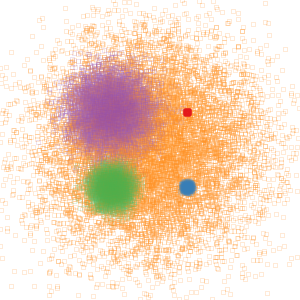

In [30]:
mask = np.array([[1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1]])

tf.shade(tf.spread(aggc, mask=mask), name="custom mask")

To support interactive zooming, where spreading would be needed only in sparse regions of the dataset, we provide the dynspread function.  `dynspread` will dynamically calculate the spreading size to use by counting the fraction of non-masked bins that have non-masked neighbors; see the
[dynspread docs](https://datashader.org/api.html#datashader.transfer_functions.dynspread) for more details.

It is worth noting that older versions of datashader only supported the
use of spread and dynspread on images containing RGBA data. This
approach is still supported:

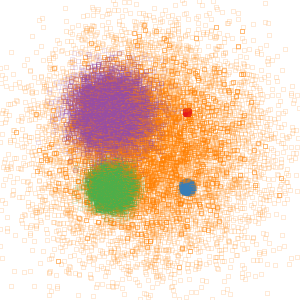

In [31]:
tf.spread(img, mask=mask)

Although both types of spreading are supported, RGB spreading
is *not* recommended as the operation is less
well defined in RGB space than aggregate space. This can be seen by
comparing the two visualizations above: the RGB spreading has fuzzy
orange areas showing through the higher valued purple distribution. In
addition, aggregate spreading preserves the numerical value of the
aggregate data, which can then be used with later processing stages
such as the [Bokeh hover inspection
tool](https://bokeh.org/) and the datashader support in
[HoloViews](http://holoviews.org/).

#### Other image transfer_functions

Other useful image operations are also provided, such as setting the background color or combining images:

In [32]:
tf.Images(tf.set_background(img,"black", name="Black bg"),
          tf.stack(img,tf.shade(aggc.sel(cat=['d2', 'd3']).sum(dim='cat')), name="Sum d2 and d3 colors"),
          tf.stack(img,tf.shade(aggc.sel(cat=['d2', 'd3']).sum(dim='cat')), how='saturate', name="d2+d3 saturated")) 

TypeError: 'numpy.float64' object cannot be interpreted as an integer

See [the API docs](https://datashader.org/api.html#transfer-functions) for more details. Image composition operators to provide for the `how` argument of `tf.stack` (e.g. `over` (default), `source`, `add`, and `saturate`) are listed in [composite.py](https://raw.githubusercontent.com/holoviz/datashader/master/datashader/composite.py) and illustrated [here](http://cairographics.org/operators).

## Moving on

The steps outlined above represent a complete pipeline from data to images, which is one way to use Datashader.  However, in practice one will usually want to add one last additional step, which is to embed these images into a plotting program to be able to get axes, legends, interactive zooming and panning, etc.  The [next notebook](3_Interactivity.ipynb) shows how to do such embedding.